# Tutorial 1 - Boolean Circuits

This tutorial covers:
- Low-level circuit construction (using `circkit` framework)
- Using existing circuits from the `wboxkit` framework (AES-128)

## Low-level circuit construction (`circkit`)

In [1]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
C = BooleanCircuit(name="maj3_and_mux")

x = C.add_input("x")
y = C.add_input("y")
z = C.add_input("z")

maj = x & y ^ x & z ^ y & z
mux = (x & z) | (~x & y)
C.add_output(maj)
C.add_output(mux)

C.print_stats()

maj3_and_mux(OptBooleanCircuit): 
   |     3 inputs,    2 outputs,     11 nodes
   | AND:4 (36.36%), INPUT:3 (27.27%), XOR:2 (18.18%), NOT:1 (9.09%), OR:1 (9.09%)


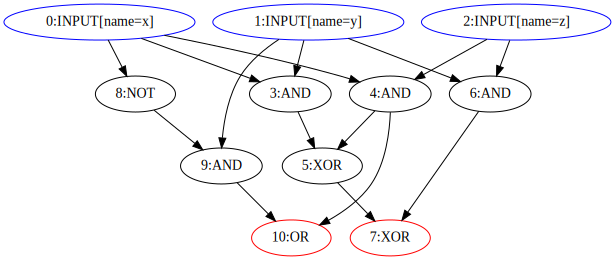

In [2]:
C.digraph()

In [3]:
C.evaluate([0, 0, 1])

[0, 0]

In [4]:
C.evaluate([1, 0, 1])

[1, 1]

## Exercise 1

Define a Boolean circuit with 4 inputs that outputs 1 on the all-zero input, and 0 otherwise. 

In [ ]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit

C = BooleanCircuit(name="maj3_and_mux")

x, y, z, w = C.add_inputs(4, "x%d")

f = ?

C.add_output(f)

assert C.evaluate([0, 0, 0, 0]) == [1]
assert C.evaluate([1, 0, 0, 0]) == [0]
assert C.evaluate([1, 1, 0, 0]) == [0]
assert C.evaluate([0, 1, 0, 1]) == [0]
assert C.evaluate([1, 1, 1, 1]) == [0]

## Vectorial Helpers

`Array` wraps a list of any objects, adds useful operations (such as rotations), and delegates various operations to the elements (which could be e.g. circuit nodes or integers or anything else (compatible)).

In [6]:
from circkit.array import Array

In [7]:
Array([0, 0, 1, 1]) ^ Array([0, 1, 0, 1])

[0, 1, 1, 0]

In [8]:
Array([0, 0, 1, 1]) & Array([0, 1, 0, 1])

[0, 0, 0, 1]

In [9]:
Array([0, 0, 0, 0, 1]).rol(2)

[0, 0, 1, 0, 0]

Now, we will create a circuit for the (simplified) Simon block cipher. This illustrates the usage of `Array`.

In [10]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from random import randrange

N_ROUNDS = 32

C = BooleanCircuit(name="Simon32")

pt = Array(C.add_inputs(32, "pt%d"))
keys = [
    Array([randrange(2) for _ in range(16)])
    for _ in range(N_ROUNDS)
]

l, r = pt.chunks(num=2)
for round in range(32):
    r ^= (l.rol(1) & l.rol(8)) ^ l.rol(2) ^ keys[round]
    l, r = r, l

ct = Array.concat(l, r)
C.add_output(ct)
print(C.evaluate([0] * 32))

[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]


## Exercise 2

Implement a circuit taking a single-bit *flag* and two 4-bit vectors, and returning the first vector if the bit is 0 and the second vector otherwise.

**Hint:** f & x ^ (~f) & y, but f should be a vector

In [ ]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit

C = BooleanCircuit(name="maj3_and_mux")

f = C.add_input("f")
x = Array(C.add_inputs(4, "x%d"))
y = Array(C.add_inputs(4, "y%d"))

x_or_y = ?
C.add_output(x_or_y)

assert C.evaluate([0] + [0, 1, 0, 1] + [1, 1, 0, 0]) == [0, 1, 0, 1]
assert C.evaluate([1] + [0, 1, 0, 1] + [1, 1, 0, 0]) == [1, 1, 0, 0]

## (Utility) Manipulation of bitstrings/ints

`binteger.Bin` is an utility module to convert and manipulate bitstrings, bytes, ints (words).

In [13]:
from binteger import Bin

In [14]:
Bin(127, 10)

Bin(0b0001111111, n=10)

In [15]:
Bin(0x4141, 16).bytes

b'AA'

In [16]:
Bin(b"AA").tuple

(0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1)

We will use `Bin` to convert `bytes` constants (plaintexts/ciphertexts, master keys) into bit sequences and vice versa.

## Existing circuits from `wboxkit` (AES-128)

In the following, we use an existing AES circuit generator from `wbkit`, to create an AES circuit with a **hardcoded key**.

In [18]:
from circkit.boolean import OptBooleanCircuit as BooleanCircuit
from wboxkit.ciphers.aes import BitAES

key = b"abcdefghABCDEFGH"
key_bits = Bin(key).tuple

C = BooleanCircuit(name="AES")
pt = C.add_inputs(128)
ct, k10 = BitAES(pt, key_bits, rounds=10)
C.add_output(ct)

C.in_place_remove_unused_nodes()
C.print_stats()

AES(OptBooleanCircuit): 
   |   128 inputs,  128 outputs,  31273 nodes
   | XOR:19284 (61.66%), AND:6240 (19.95%), NOT:5621 (17.97%), INPUT:128 (0.41%)


In [19]:
plaintext = b"0123456789abcdef"
ciphertext_bits = C.evaluate(Bin(plaintext).tuple)
ciphertext = Bin(ciphertext_bits).bytes
ciphertext.hex()

'54b03463c5b5a1d45efb4e91637ba51f'

In [20]:
from Crypto.Cipher import AES

AES.new(key, mode=AES.MODE_ECB).encrypt(plaintext).hex()

'54b03463c5b5a1d45efb4e91637ba51f'

We can also let the key be an extra input.

In [21]:
C = BooleanCircuit(name="AES")

pt = C.add_inputs(128)
key = C.add_inputs(128)

ct, k10 = BitAES(pt, key, rounds=10)

C.add_output(ct)

C.in_place_remove_unused_nodes()

C.print_stats()

AES(OptBooleanCircuit): 
   |   256 inputs,  128 outputs,  39893 nodes
   | XOR:25452 (63.80%), AND:7800 (19.55%), NOT:6385 (16.01%), INPUT:256 (0.64%)


In [22]:
test_plaintext = b"0123456789abcdef"
test_key = b"abcdefghABCDEFGH"

test_ciphertext = C.evaluate(Bin(test_plaintext + test_key).tuple)
test_ciphertext = Bin(test_ciphertext).bytes
test_ciphertext.hex()

'54b03463c5b5a1d45efb4e91637ba51f'

Sanity test that a change in the key affects the ciphertext:

In [23]:
test_plaintext = b"0123456789abcdef"
test_key = b"abcdefghABCDEFGh"

test_ciphertext = C.evaluate(Bin(test_plaintext + test_key).tuple)
test_ciphertext = Bin(test_ciphertext).bytes
test_ciphertext.hex()

'4c78f17f5a638a244d6d7409fdc037e8'

## Exercise 3

Implement an AES-based PRF $F_k(x) = x \oplus E_k(x)$ with a given fixed (hardcoded) master key.

In [ ]:
key = Bin(b"abcdefghABCDEFGH").tuple
C = BooleanCircuit(name="AES-PRF")
pt = Array(C.add_inputs(128))
ct = ?
C.add_output(ct)
assert Bin(C.evaluate([0, 0, 0, 1] * 32)).bytes == b'c>\xbc\xa2*\x17\x96\xbb\x95\xc3Qr\xfb\xfb\xdd\x89'

## Exercise 4

Implement a `TripleAES` circuit using 3 different hardcoded keys $k_1,k_2,k_3$:

$C(x) = E_{k_3}(E_{k_2}(E_{k_1}(x))).$

In [27]:
k1 = Bin(b"abcdefghABCDEFGH").tuple
k2 = Bin(b"exerciseEXERCISE").tuple
k3 = Bin(b"________________").tuple

C = BooleanCircuit(name="TripleAES")
s = Array(C.add_inputs(128))
s = ?
C.add_output(s)

assert Bin(C.evaluate([0, 0, 0, 1] * 32)).bytes == b"z3v\x89\xf8L']\xbcrp1\xcbn[\xf1"